In [230]:
import pandas as pd
import numpy as np
import joblib as saver
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split , RandomizedSearchCV , learning_curve
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as NN
import torch.optim as optim

In [231]:
path = "train.csv"
data = pd.read_csv(path)
shape = data.shape
colmns = data.columns
print("data's shape : " , shape)
print("data's columns : " , list(colmns))
data.sample(3)

data's shape :  (1460, 81)
data's columns :  ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3S

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
842,843,80,RL,82.0,9020,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,5,2008,WD,Normal,174900
1176,1177,20,RL,37.0,6951,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2008,WD,Normal,119500
556,557,20,RL,69.0,14850,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnWw,NaN,0,5,2006,WD,Normal,141000


In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [233]:
def get_objects(data , features , show=False):
    objects = []
    for col in features:
        if data[col].dtype == 'object':
            objects.append(col)
    if show:
        print("object columns : \n" , list(objects))
    return data , objects
data , objects = get_objects(data , data.columns , show=True)    

object columns : 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [234]:
def null_values(features, threshold, results=False , drop=False):
    strong_nans = []
    weak_nans = []

    for col in features:
        nans = data[col].isnull().sum()
        print(f"{col} : {nans}")
        
        if nans > threshold:
            strong_nans.append(col)
        elif nans > 0:
            weak_nans.append(col)

    if results:
        print(f"\n Columns with > {threshold} NaNs: {len(strong_nans)}")
        print(f" Columns with ≤ {threshold} and > 0 NaNs: {len(weak_nans)}")

    if drop:
        data.drop(columns=strong_nans , inplace=True)
        print("strong nans'c columns dropped successfuly !")

    return strong_nans, weak_nans
strong_nans , weak_nans = null_values(objects , 100 , results=True , drop=True)

MSZoning : 0
Street : 0
Alley : 1369
LotShape : 0
LandContour : 0
Utilities : 0
LotConfig : 0
LandSlope : 0
Neighborhood : 0
Condition1 : 0
Condition2 : 0
BldgType : 0
HouseStyle : 0
RoofStyle : 0
RoofMatl : 0
Exterior1st : 0
Exterior2nd : 0
MasVnrType : 872
ExterQual : 0
ExterCond : 0
Foundation : 0
BsmtQual : 37
BsmtCond : 37
BsmtExposure : 38
BsmtFinType1 : 37
BsmtFinType2 : 38
Heating : 0
HeatingQC : 0
CentralAir : 0
Electrical : 1
KitchenQual : 0
Functional : 0
FireplaceQu : 690
GarageType : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
PavedDrive : 0
PoolQC : 1453
Fence : 1179
MiscFeature : 1406
SaleType : 0
SaleCondition : 0

 Columns with > 100 NaNs: 6
 Columns with ≤ 100 and > 0 NaNs: 10
strong nans'c columns dropped successfuly !


In [235]:
objcs = weak_nans
data[objcs].isnull().sum()
for col in objcs:
    data[col].fillna("Unknown" , inplace=True)
data[objcs].nunique()    

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17384\1746208276.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna("Unknown" , inplace=True)


BsmtQual        5
BsmtCond        5
BsmtExposure    5
BsmtFinType1    7
BsmtFinType2    7
Electrical      6
GarageType      7
GarageFinish    4
GarageQual      6
GarageCond      6
dtype: int64

In [236]:
def encode(data, feats , save=False):
    encoders = {}
    for col in feats:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col].astype(str))
        encoders[col] = encoder 
    if save:
        saver.dump(encoders , "encoders.joblib")
        print("encoders saved in 'encoders.joblib' file")
    return data , encoders

In [237]:
data , objects = get_objects(data , data.columns , show=True)
data , encoders = encode(data , objects , save=True)

object columns : 
 ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
encoders saved in 'encoders.joblib' file


In [238]:
def strong_corr_features(data, target_col, threshold=0.5, show=True):

    numeric_data = data.select_dtypes(include=['int64', 'float64'])
    correlations = numeric_data.corr()[target_col].drop(target_col)
    strong_feats = correlations[correlations.abs() > threshold].sort_values(ascending=False)
    
    if show:
        print(f"\nFeatures strongly correlated with '{target_col}' ( |correlation| > {threshold} ):")
        print(strong_feats)
        print("length : " , len(strong_feats),"column")
    
    return strong_feats.index.tolist()

strong_features = strong_corr_features(data , 'SalePrice' , threshold=0.5 , show=True)


Features strongly correlated with 'SalePrice' ( |correlation| > 0.5 ):
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageFinish   -0.549247
KitchenQual    -0.589189
BsmtQual       -0.620886
ExterQual      -0.636884
Name: SalePrice, dtype: float64
length :  14 column


In [239]:
target = data['SalePrice']
data = data[strong_features]
data.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageFinish,KitchenQual,BsmtQual,ExterQual
0,7,1710,2,548,856,856,2,8,2003,2003,1,2,2,2
1,6,1262,2,460,1262,1262,2,6,1976,1976,1,3,2,3
2,7,1786,2,608,920,920,2,6,2001,2002,1,2,2,2
3,7,1717,3,642,756,961,1,7,1915,1970,2,2,3,3
4,8,2198,3,836,1145,1145,2,9,2000,2000,1,2,2,2


In [240]:
def MinMax(data , features):
    for col in features:
        mx = data[col].max()
        mn = data[col].min()
        print(f"{col} : max = {mx} | min = {mn}")

MinMax(data , data.columns)
feats_to_scale = ['GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','YearBuilt','YearRemodAdd']
print('-'*192)

def scale(data , features , show =False , save = False):
    scaled = {}
    for col in features:
        scaler = StandardScaler()
        data[col] = scaler.fit_transform(data[[col]])
        scaled[col] = scaler
    if show:
        print("columns scaled :")
        s = []
        for k , v in scaled.items():
            s.append(k)
        print(list(s))    
    if save:
        saver.dump(scaled , 'scaled.joblib')    
        print("saved successfuly in 'scaled.joblib' file")

scale(data , feats_to_scale , show=True , save=True)    

OverallQual : max = 10 | min = 1
GrLivArea : max = 5642 | min = 334
GarageCars : max = 4 | min = 0
GarageArea : max = 1418 | min = 0
TotalBsmtSF : max = 6110 | min = 0
1stFlrSF : max = 4692 | min = 334
FullBath : max = 3 | min = 0
TotRmsAbvGrd : max = 14 | min = 2
YearBuilt : max = 2010 | min = 1872
YearRemodAdd : max = 2010 | min = 1950
GarageFinish : max = 3 | min = 0
KitchenQual : max = 3 | min = 0
BsmtQual : max = 4 | min = 0
ExterQual : max = 3 | min = 0
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
columns scaled :
['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd']
saved successfuly in 'scaled.joblib' file


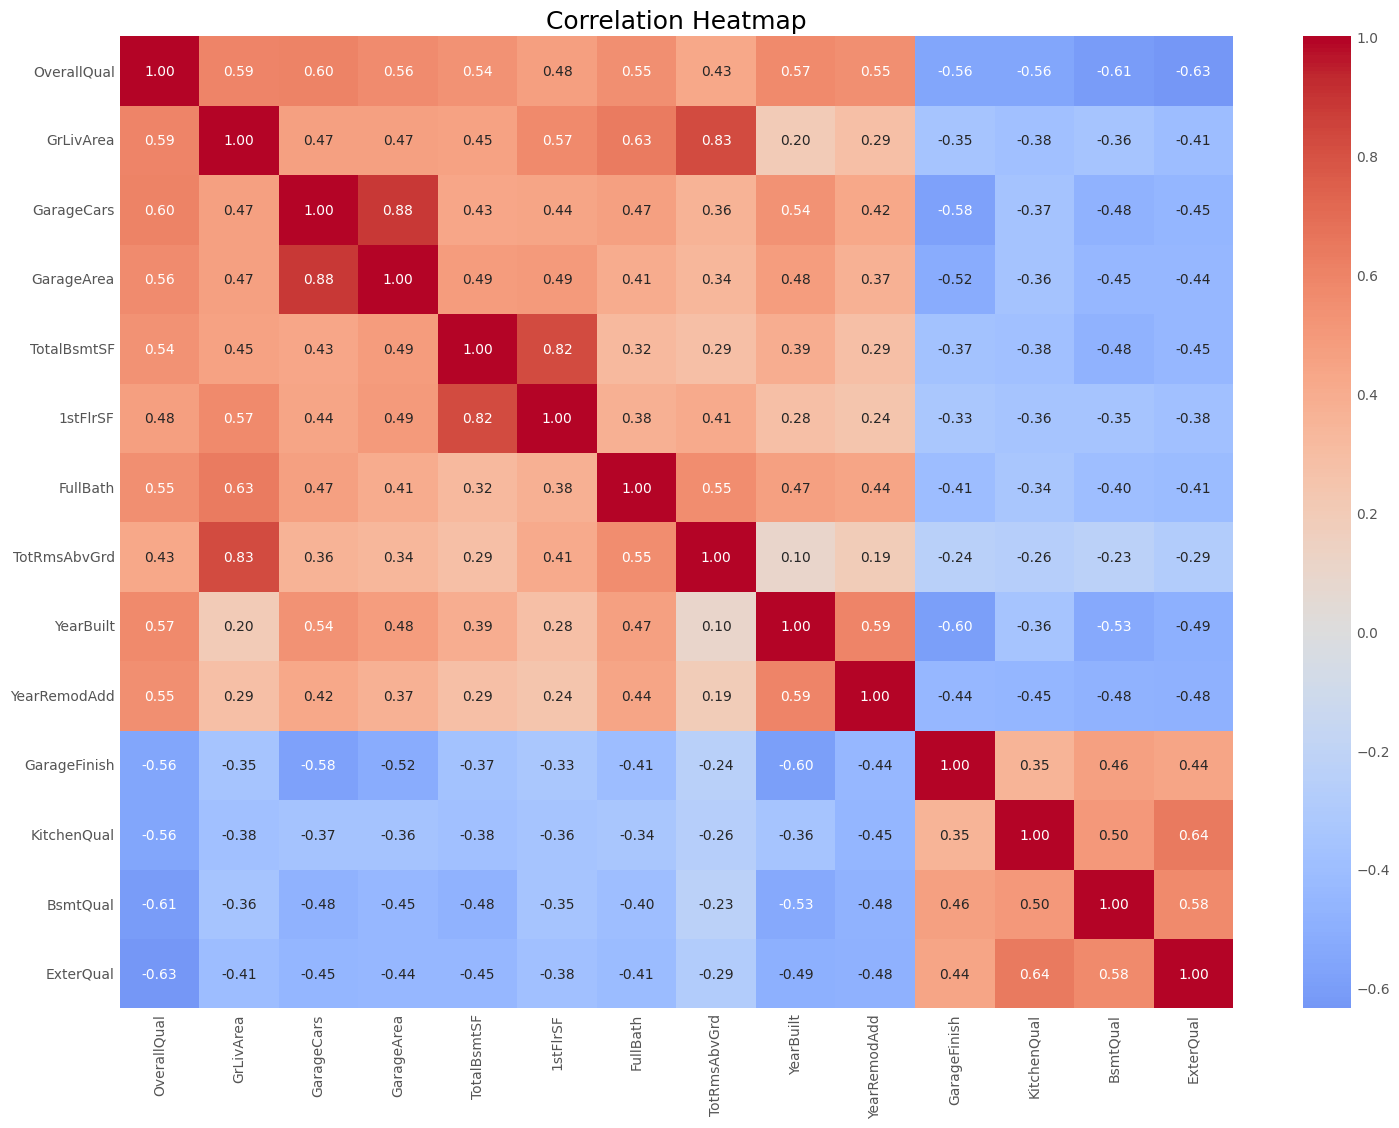

In [241]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(16, 12))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap", fontsize=18)
plt.show()

max price :  755000 $
min price : 34900 $


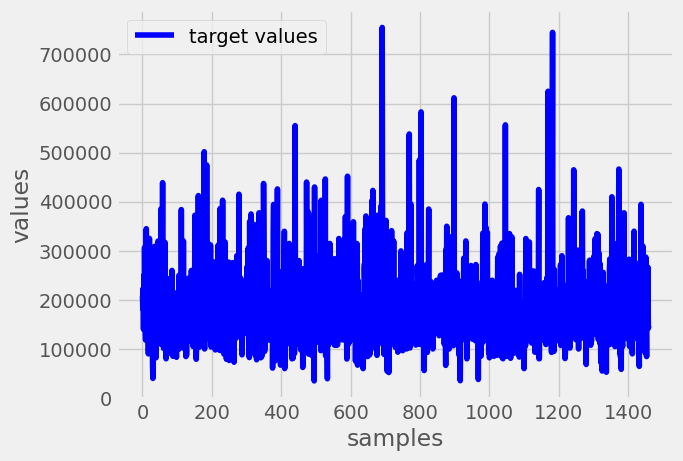

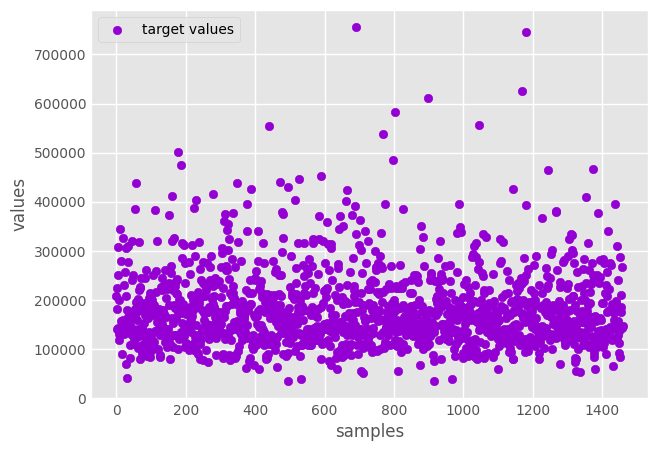

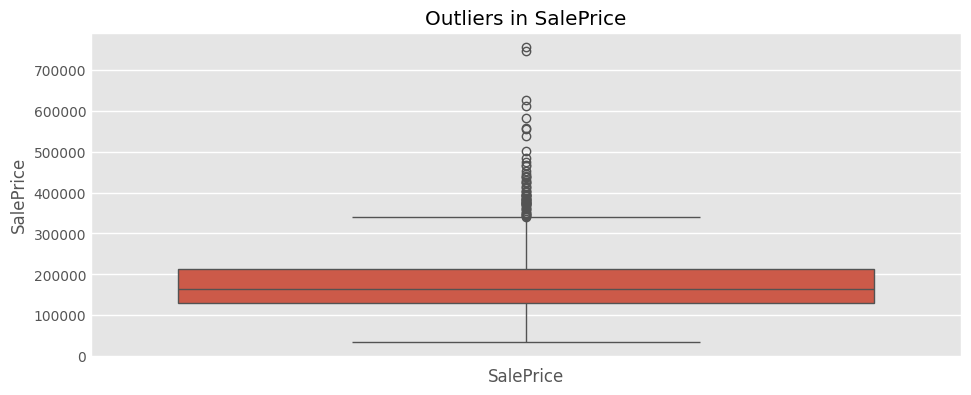

In [242]:
print("max price : " , target.max().tolist(), "$")
print("min price :",target.min().tolist(), "$")

plt.style.use("fivethirtyeight")
plt.plot(range(len(target)) , target.to_numpy() , c='blue' , label='target values')
plt.xlabel("samples")
plt.ylabel("values")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.scatter(range(len(target)) , target.to_numpy() , c='darkviolet', label = 'target values')
plt.xlabel("samples")
plt.ylabel("values")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(target)
plt.title("Outliers in SalePrice")
plt.xlabel("SalePrice")
plt.show()



In [243]:
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(target < lower_bound) | (target > upper_bound)]

print(f"Number of outliers in SalePrice: {len(outliers)}")
print(f"Acceptable range: {int(lower_bound)}$ → {int(upper_bound)}$")

Number of outliers in SalePrice: 61
Acceptable range: 3937$ → 340037$


In [244]:
data = pd.concat([data, target], axis=1)
data = data[(target >= lower_bound) & (target <= upper_bound)]
data.columns
data.shape

(1399, 15)

In [ ]:
x = data.drop(columns=['SalePrice'] , axis=1)
y = data['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=97)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best estimator :  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=633,
             n_jobs=None, num_parallel_tree=None, ...)
best parameters :  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 633, 'subsample': 0.6}
best score : -0.023
MAE: 162768.291
MSE: 28801312969

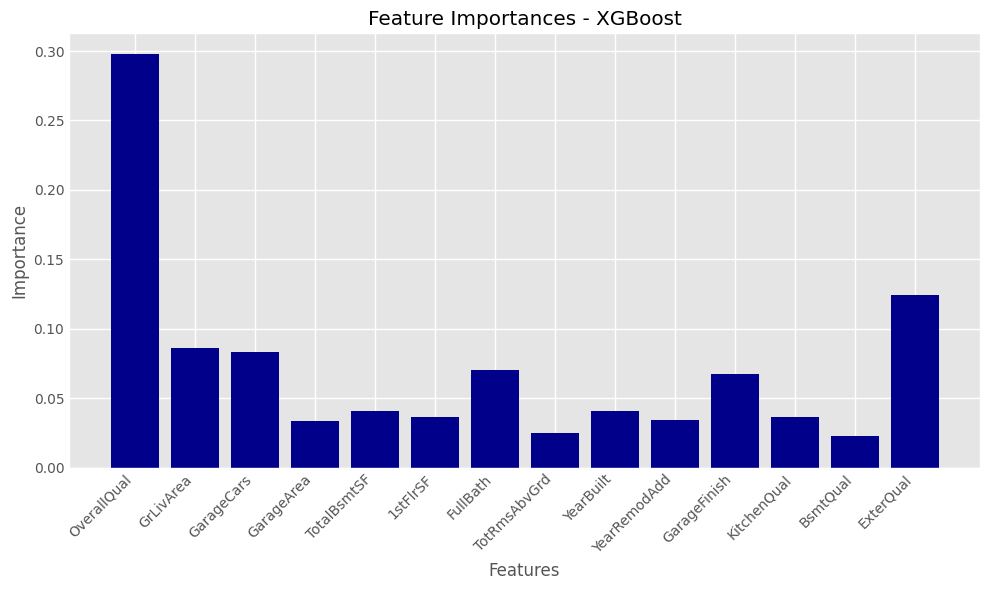

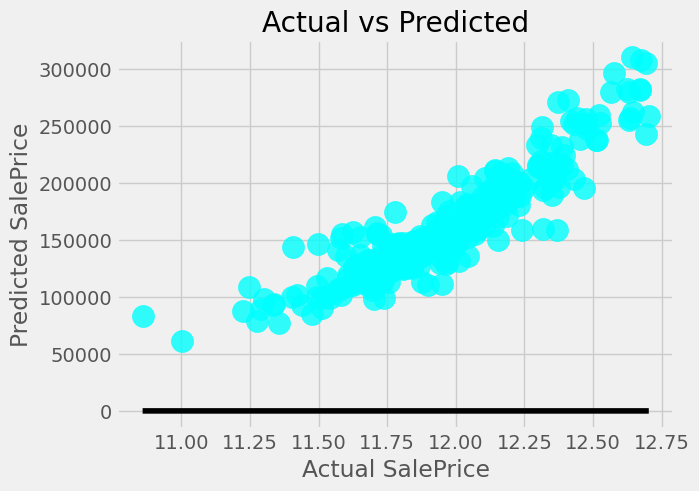

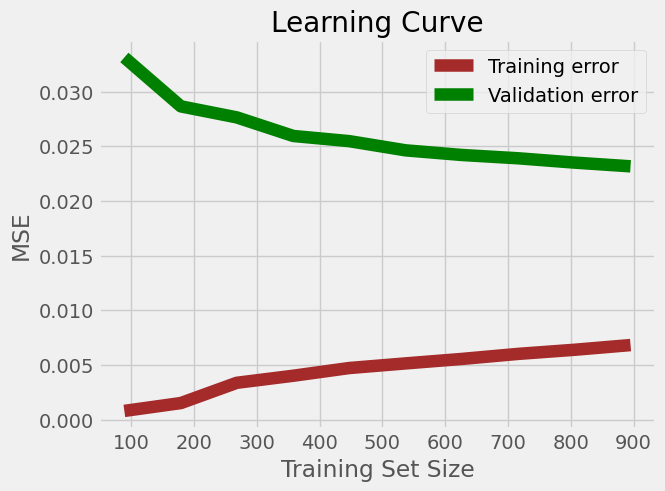

In [ ]:
model1 = XGBRegressor()
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
params = {
    'n_estimators': randint(400 , 700) , 
    'learning_rate': [0.001 , 0.01 , 0.1], 
    'max_depth': randint(2 , 12), 
    'subsample': [0.6 , 0.8 , 0.9], 
    'colsample_bytree': [0.5, 0.7 , 0.8 , 1], 
}
xgbsearch = RandomizedSearchCV(model1 , 
                               params , 
                               cv=5 , 
                               random_state=123 , 
                               n_iter=40 , 
                               n_jobs=-1 , 
                               verbose=1 , 
                               scoring='neg_mean_squared_error')

xgbsearch.fit(x_train , y_train)
bst_estim = xgbsearch.best_estimator_
bst_params = xgbsearch.best_params_
bst_score = xgbsearch.best_score_

preds = bst_estim.predict(x_test)

print("best estimator : " , bst_estim)
print("best parameters : " , bst_params)
print(f"best score : {bst_score:.3f}")

mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2*100:.2f}%")

ft_imp = bst_estim.feature_importances_
columns = x_train.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(ft_imp)), ft_imp, color='darkblue')
plt.xticks(range(len(columns)), columns, rotation=45, ha='right')
plt.title("Feature Importances - XGBoost")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.style.use("fivethirtyeight")
plt.scatter(y_test, preds , s=250 , alpha=0.8 , c='cyan')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='black') 
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted")
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    bst_estim, x_train, y_train, cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error' , c= 'brown' , linewidth = 9)
plt.plot(train_sizes, test_scores_mean, label='Validation error' , c= 'green' , linewidth = 9)
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.title("Learning Curve")
plt.legend()
plt.show()

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best estimator: RandomForestRegressor(max_depth=8, max_features=0.6, min_samples_leaf=2,
                      min_samples_split=14, n_estimators=423, random_state=42)
best parameters: {'max_depth': 8, 'max_features': 0.6, 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 423}
best score : 0.813
MAE : 162768.291
MSE : 28801312969.229
R²: -27260839475870.55%


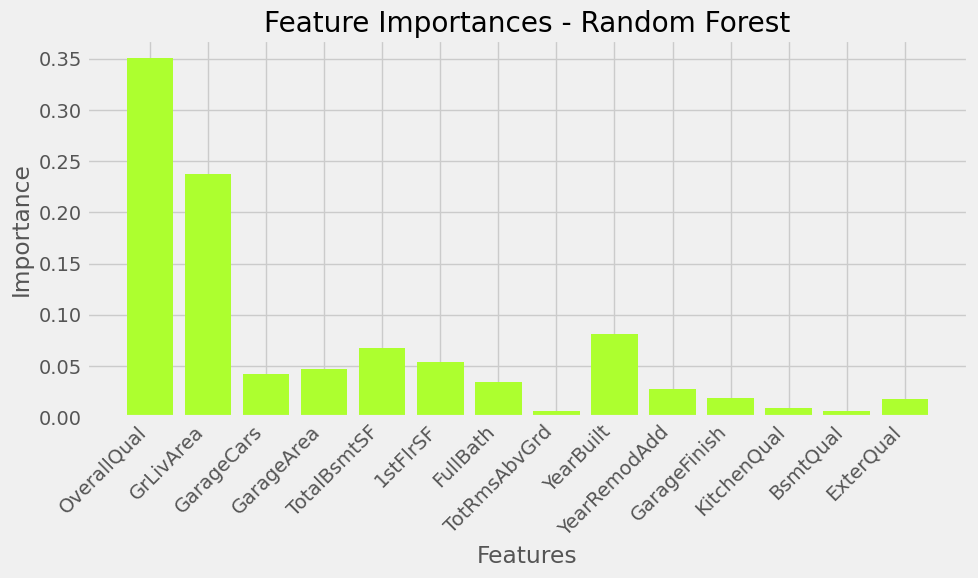

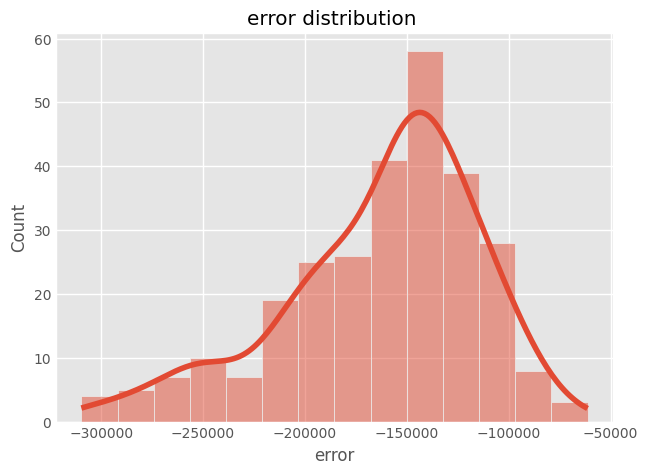

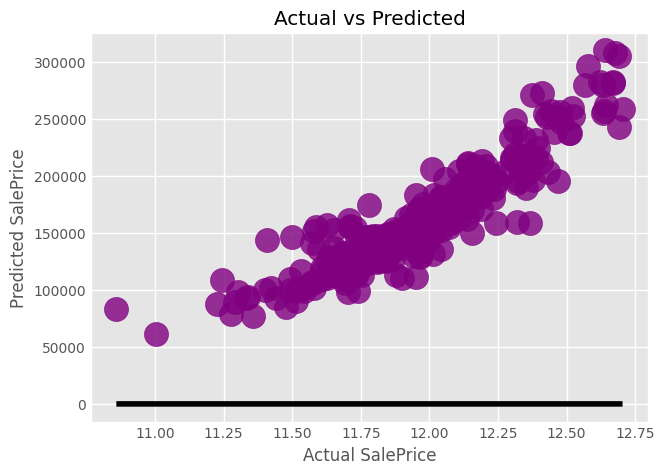

In [ ]:
model2 = RandomForestRegressor(random_state=42)

params2 = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(2, 15),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [0.6, 0.8, 1.0] , 
}

rf_search = RandomizedSearchCV(
    model2,
    params2,
    cv=5,
    random_state=123,
    n_iter=40,
    n_jobs=-1,
    verbose=1,
)


rf_search.fit(x_train, y_train)
bst_estim2 = rf_search.best_estimator_
bst_params2 = rf_search.best_params_
bst_score2 = rf_search.best_score_
preds2 = bst_estim2.predict(x_test)

print("best estimator:", bst_estim2)
print("best parameters:", bst_params2)
print(f"best score : {bst_score2:.3f}")

mae2 = mean_absolute_error(y_test, preds2)
mse2 = mean_squared_error(y_test, preds2)
r22 = r2_score(y_test, preds2)

print(f"MAE : {mae2:.3f}")
print(f"MSE : {mse2:.3f}")
print(f"R²: {r22*100:.2f}%")

ft_imp2 = bst_estim2.feature_importances_
columns2 = x_train.columns

plt.style.use("fivethirtyeight")
plt.figure(figsize=(10, 6))
plt.bar(range(len(ft_imp2)), ft_imp2, color='greenyellow')
plt.xticks(range(len(columns2)), columns2, rotation=45, ha='right')
plt.title("Feature Importances - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

errors = y_test - preds
plt.style.use("ggplot")
sns.histplot(errors, kde=True)
plt.title("error distribution ")
plt.xlabel("error")
plt.show()

plt.style.use("ggplot")
plt.scatter(y_test, preds2, alpha=0.8 , s=300 , c='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c= 'black')  
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted")
plt.show()


In [248]:
x_train.shape[1]

'''
neural network model plan : 
input_size → 64 → ReLU
64 → 128 → ReLU
128 → 64 → ReLU
64 → 32 → ReLU
32 → 1  → no activation '''

'\nneural network model plan : \ninput_size → 64 → ReLU\n64 → 128 → ReLU\n128 → 64 → ReLU\n64 → 32 → ReLU\n32 → 1  → no activation '

In [ ]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [249]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)  
x_test = torch.tensor(x_test.values, dtype=torch.float32)    
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [250]:
input_size = x_train.shape[1]
class NeuralNetwork(NN.Module):
    def __init__(self):
        super().__init__()
        self.hlayer1 = NN.Linear(input_size , 64)
        self.hlayer2 =  NN.Linear(64 , 128)
        self.hlayer3 = NN.Linear(128 , 64)
        self.hlayer4 = NN.Linear(64 , 32)
        self.output = NN.Linear(32 , 1)

    def forward(self , x):
        x = torch.relu(self.hlayer1(x)) 
        x = torch.relu(self.hlayer2(x)) 
        x = torch.relu(self.hlayer3(x)) 
        x = torch.relu(self.hlayer4(x)) 
        x = self.output(x)
        return x

model = NeuralNetwork()
loss_fn = NN.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)    
epochs = 5000

for epoch in range(epochs):
    
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fn(y_pred , y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.3f}")

Epoch 100/5000, Loss: 0.597
Epoch 200/5000, Loss: 0.482
Epoch 300/5000, Loss: 0.416
Epoch 400/5000, Loss: 0.328
Epoch 500/5000, Loss: 0.231
Epoch 600/5000, Loss: 0.162
Epoch 700/5000, Loss: 0.119
Epoch 800/5000, Loss: 0.091
Epoch 900/5000, Loss: 0.076
Epoch 1000/5000, Loss: 0.066
Epoch 1100/5000, Loss: 0.058
Epoch 1200/5000, Loss: 0.051
Epoch 1300/5000, Loss: 0.044
Epoch 1400/5000, Loss: 0.038
Epoch 1500/5000, Loss: 0.027
Epoch 1600/5000, Loss: 0.023
Epoch 1700/5000, Loss: 0.021
Epoch 1800/5000, Loss: 0.020
Epoch 1900/5000, Loss: 0.019
Epoch 2000/5000, Loss: 0.018
Epoch 2100/5000, Loss: 0.018
Epoch 2200/5000, Loss: 0.017
Epoch 2300/5000, Loss: 0.017
Epoch 2400/5000, Loss: 0.017
Epoch 2500/5000, Loss: 0.017
Epoch 2600/5000, Loss: 0.016
Epoch 2700/5000, Loss: 0.016
Epoch 2800/5000, Loss: 0.016
Epoch 2900/5000, Loss: 0.015
Epoch 3000/5000, Loss: 0.015
Epoch 3100/5000, Loss: 0.016
Epoch 3200/5000, Loss: 0.015
Epoch 3300/5000, Loss: 0.015
Epoch 3400/5000, Loss: 0.015
Epoch 3500/5000, Loss: 

In [251]:
model.eval()
with torch.no_grad():
    predictions = model(x_test)

mae_ = mean_absolute_error(y_test , predictions)
mse_ = mean_squared_error(y_test , predictions)

print("mean squared error : " , mse_)
print("mean absolute error : " , mae_)

mean squared error :  0.0290942084431338
mean absolute error :  0.12054003306797573
